In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
n_samples = 50

In [13]:
x_axis_a = np.linspace(-1.,-0.3,n_samples,endpoint=True).reshape(-1,1)
x_axis_b = np.linspace(0.2,1,n_samples,endpoint=True).reshape(-1,1)

cov_noise = np.eye(2)*0.01
cov_noise[1,1] *=3 

gaussian_noise = np.random.multivariate_normal(mean=np.zeros(2),cov=cov_noise, size=(n_samples))

y_axis_a = (1-x_axis_a**2).reshape(-1,1)
y_axis_b = (1-x_axis_b**2).reshape(-1,1)

a_group = np.hstack((x_axis_a,-np.sqrt(y_axis_a)))
b_group = np.hstack((x_axis_b,np.sqrt(y_axis_b)))

unif_noise_a = np.random.uniform(low=-0.05,high=0.05,size=(n_samples,2))
unif_noise_b = np.random.uniform(low=-0.05,high=0.05,size=(n_samples,2))

a_group += unif_noise_a
b_group += unif_noise_b


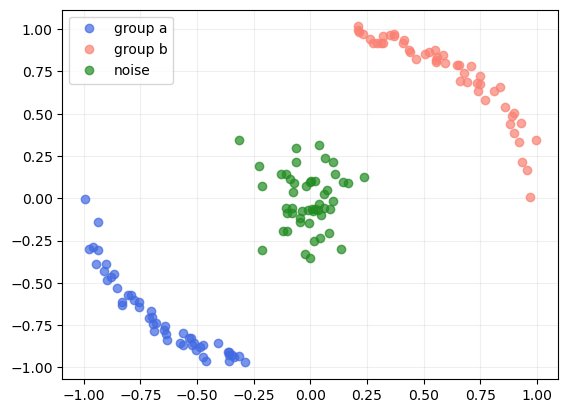

In [15]:
fig, ax = plt.subplots()
ax.plot(a_group[:,0],a_group[:,1],'o',color='royalblue',alpha=0.7,label='group a')
ax.plot(b_group[:,0],b_group[:,1],'o',color='salmon',alpha=0.7,label='group b')
ax.plot(gaussian_noise[:,0], gaussian_noise[:,1],'o', color='forestgreen',alpha=0.7,label='noise')
ax.grid(alpha=0.2)
ax.legend()